# Prepare Enviroment 

In [1]:
%%capture
!pip install torchsummary
!pip install lightning
!pip install albumentations
!pip install timm
!pip install audiomentations
!pip install torch-audiomentations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import librosa 
import librosa.display
from sklearn.model_selection import train_test_split
import torchaudio
import torch
from torchvision import transforms
import torch.nn.functional as F
from IPython.display import Audio, display
import numpy as np
import torchaudio

In [3]:
# Set the seed for reproducibility
# The seed is used to initialize the pseudorandom number generator used by the random module.
# It's benificial to set the seed so that the results are reproducible.
# The 1234 is just a random number I chose.
seed=1234                       
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


# Load DataFrame

In [5]:
train_path = '/kaggle/input/cutting-tool-wear-audio-dataset/SegmentedData'
print(len(os.listdir(train_path)))

8


In [6]:
# Define the file pattern and paths
file_pattern = train_path+"/**/*.wav"
recursive = True

# Define the function to process each file
def process_file(file):
    if os.stat(file).st_size == 0:
        return None
    label =  file.split("/")[-2]
    return {"file": file, "label": label}

# Glob and apply the function to each file
data = pd.DataFrame([process_file(file) for file in glob.glob(file_pattern, recursive=recursive)],columns=['file','label'])


In [7]:
print('The shape of the training data is: ', data.shape)


The shape of the training data is:  (1488, 2)


In [8]:
data.head()

file     label
0  /kaggle/input/cutting-tool-wear-audio-dataset/...  FRESH635
1  /kaggle/input/cutting-tool-wear-audio-dataset/...  FRESH635
2  /kaggle/input/cutting-tool-wear-audio-dataset/...  FRESH635
3  /kaggle/input/cutting-tool-wear-audio-dataset/...  FRESH635
4  /kaggle/input/cutting-tool-wear-audio-dataset/...  FRESH635

## Unique Labels

In [9]:
uniq_labels = data.label.unique()
print('There are a total of', len(uniq_labels), 'unique labels.\n')
print(uniq_labels)

There are a total of 8 unique labels.

['FRESH635' 'MODERATE635' 'BASE520' 'MODERATE520' 'BROKEN635' 'BROKEN520'
 'FRESH520' 'BASE635']


## split dataset

In [10]:
from sklearn.model_selection import train_test_split
train,valid=train_test_split(data, test_size=0.20, random_state=seed,stratify=data['label'])
train.reset_index(inplace=True,drop=True)
valid.reset_index(inplace=True,drop=True)

In [11]:
train=pd.concat([train['file'],pd.get_dummies(train['label'], dtype=float)],axis=1)
valid=pd.concat([valid['file'],pd.get_dummies(valid['label'], dtype=float)],axis=1)

# Exploring Samples and analysize

In [103]:
sample1, sample_rate1 = torchaudio.load(data['file'][20])
play_audio(sample1,sample_rate1)
print(sample1.shape)
sample1, sample_rate1

torch.Size([2, 480000])


(tensor([[ 0.0461,  0.0411,  0.0378,  ..., -0.0374, -0.0698, -0.0138],
         [ 0.0461,  0.0411,  0.0378,  ..., -0.0374, -0.0698, -0.0138]]),
 48000)

In [104]:
torch.mean(sample1), torch.std(sample1), torch.min(sample1), torch.max(sample1)

(tensor(1.6786e-05), tensor(0.0585), tensor(-0.4058), tensor(0.3590))

In [105]:
sr=16000
Resample=torchaudio.transforms.Resample(sample_rate1,) # 44000
sample1=Resample(sample1)

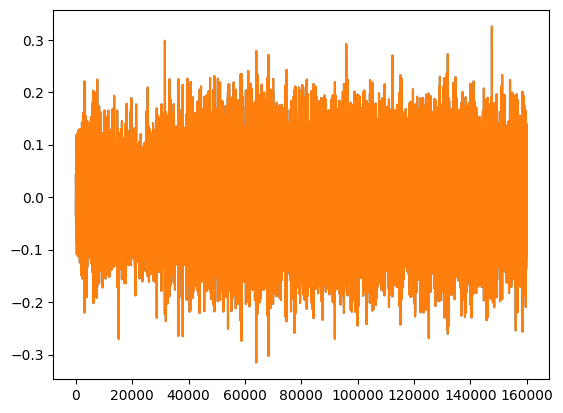

In [106]:
plt.plot(sample1.t().numpy())

In [107]:
sample1.shape

torch.Size([2, 160000])

In [108]:
sample1.shape[1]/16000

10.0

In [109]:
sample1.shape

torch.Size([2, 160000])

### MFCC

In [110]:
mfcc_spectrogram = torchaudio.transforms.MFCC(

        n_mfcc=128
)

Shape of spectrogram: torch.Size([2, 128, 801])
tensor(-4.2633) tensor(14.9341) tensor(-165.9060) tensor(61.7671)


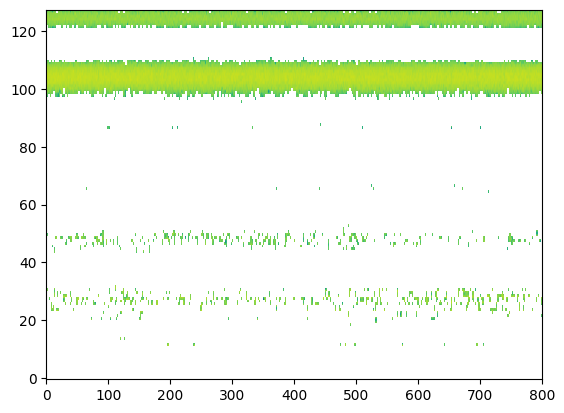

In [111]:
specgram = mfcc_spectrogram(sample1) # specgram = torchaudio.transforms.Spectrogram()(F.pad(sample1, [0,int(np.mean(audio_files))-sample1.shape[1]]))

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='viridis', aspect="auto", origin="lower")
print((specgram).mean(),(specgram).std(),(specgram).min(),(specgram).max())

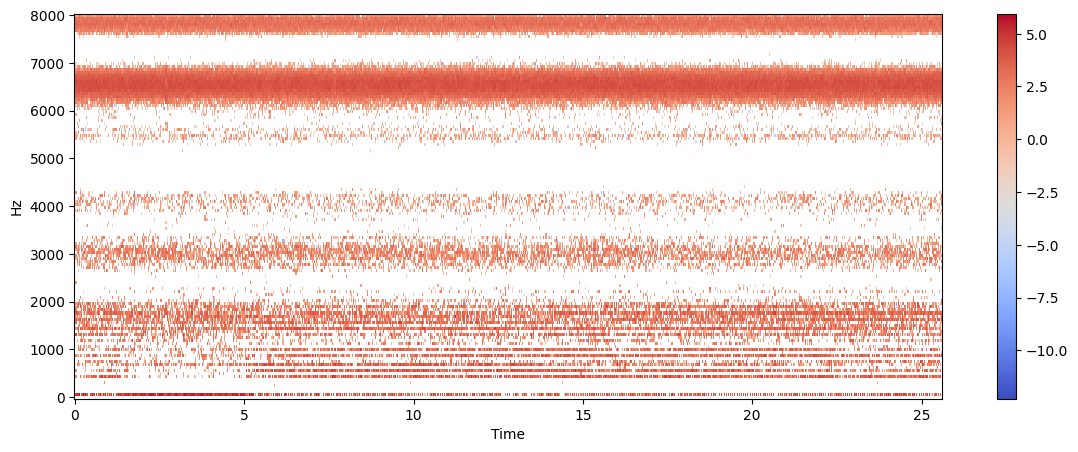

In [112]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(specgram.log2()[0,:,:].numpy(), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### mel_spectrogram

In [113]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=64,n_fft=1024)

Shape of spectrogram: torch.Size([2, 64, 313])
tensor(9.3375) tensor(20.9556) tensor(0.0161) tensor(292.7954)


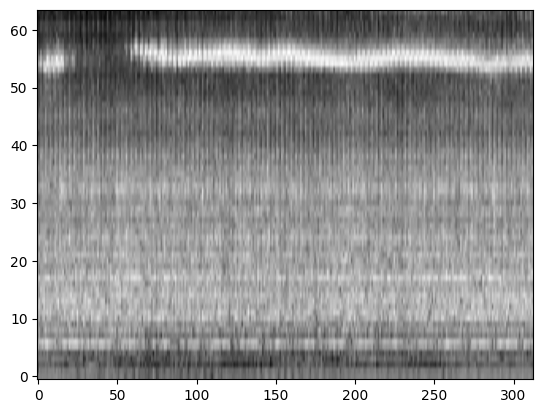

In [114]:
specgram = mel_spectrogram(sample1) # specgram = torchaudio.transforms.Spectrogram()(F.pad(sample1, [0,int(np.mean(audio_files))-sample1.shape[1]]))

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray',aspect="auto", origin="lower")
print((specgram).mean(),(specgram).std(),(specgram).min(),(specgram).max())

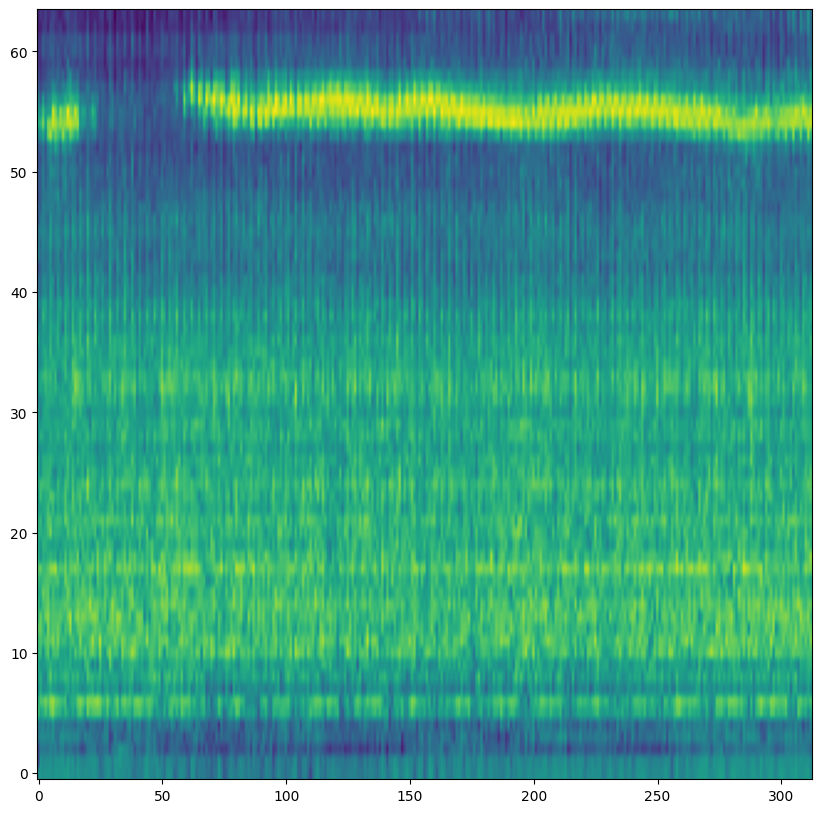

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(np.expand_dims(specgram.log2()[0,:,:].numpy(), axis=2), cmap='viridis', aspect="auto", origin="lower")
plt.show()

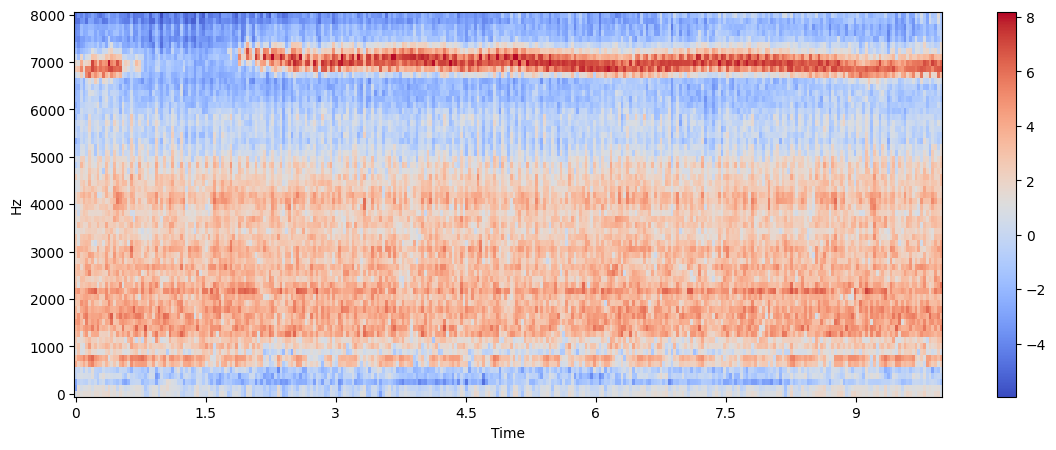

In [116]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(specgram.log2()[0,:,:].numpy(), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### ***AmplitudeToDB***

In [117]:
transform = torchaudio.transforms.AmplitudeToDB(stype="magnitude",top_db=80)
print(transform(specgram).mean(),transform(specgram).std(),transform(specgram).min(),transform(specgram).max())

tensor(9.0435) tensor(14.3314) tensor(-30.6687) tensor(49.3313)


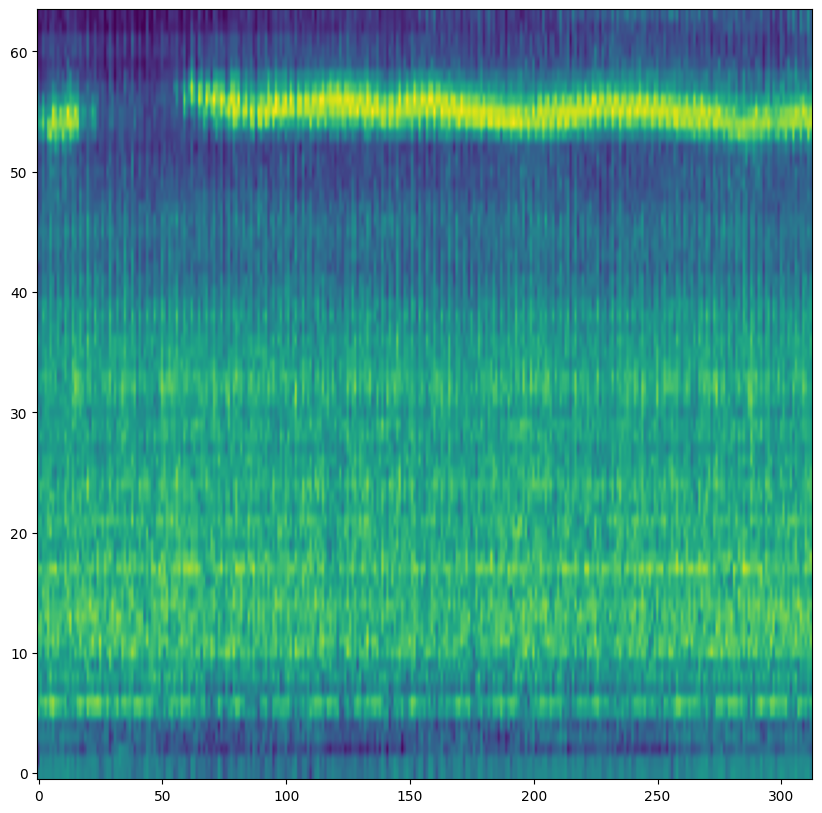

In [118]:
plt.figure(figsize=(10,10))
plt.imshow(np.expand_dims(transform(specgram)[0].numpy(), axis=2), cmap='viridis', aspect="auto", origin="lower")
plt.show()

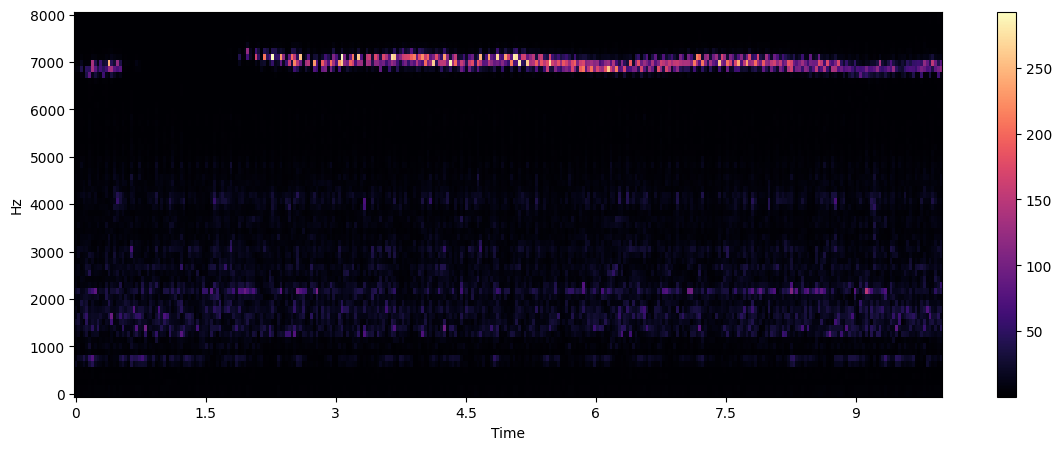

In [119]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(specgram[0].numpy(), sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

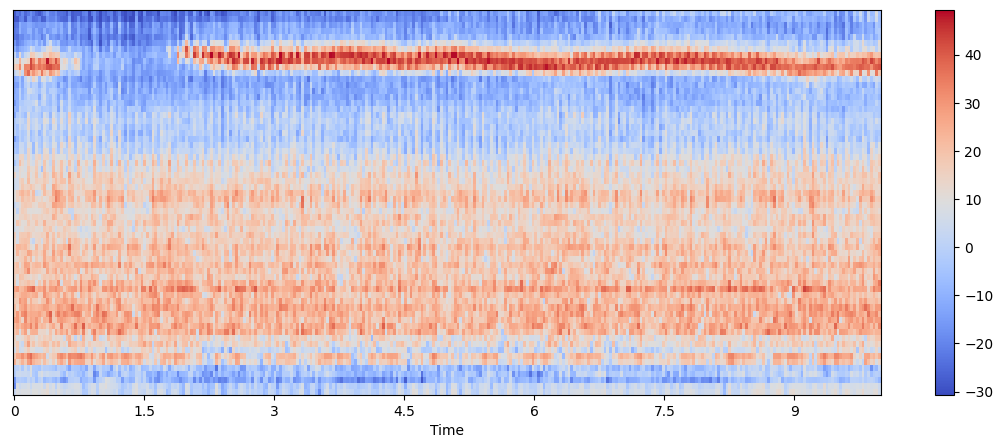

In [120]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(transform(specgram)[0].numpy(), sr=sr, x_axis='time')
plt.colorbar()

### TimeMasking

In [121]:
masking = torchaudio.transforms.TimeMasking(time_mask_param=10)
spec = masking(specgram)
spec.shape

torch.Size([2, 64, 313])

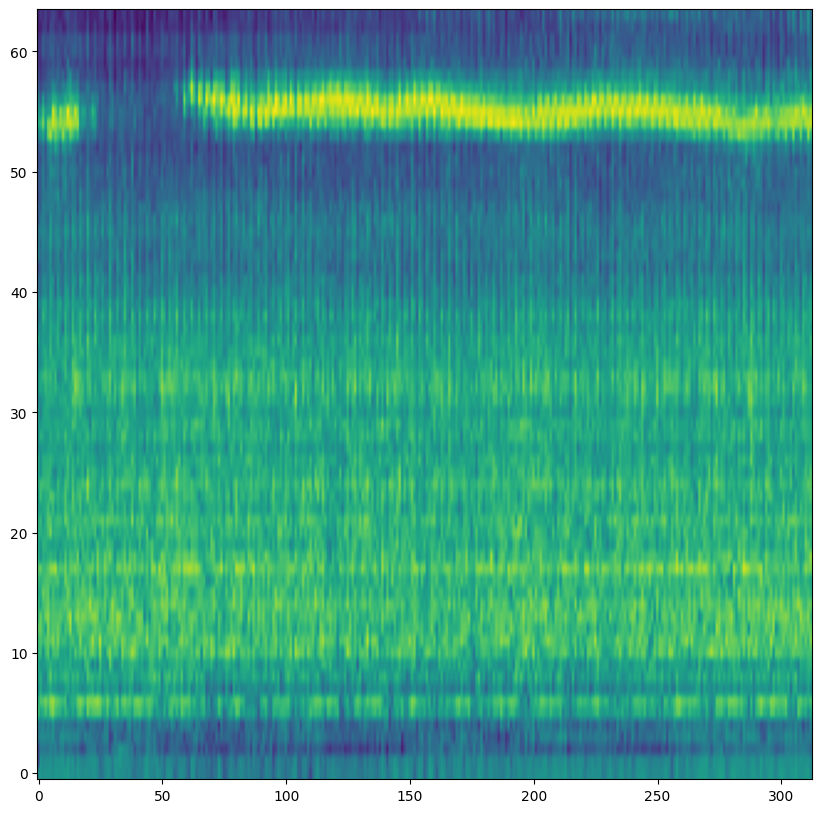

In [122]:
plt.figure(figsize=(10,10))
plt.imshow(np.expand_dims(spec.log2()[0,:,:].numpy(), axis=2), cmap='viridis', aspect="auto", origin="lower")
plt.show()

In [130]:
play_audio(torch.Tensor(waveform2[0].unsqueeze(0)),sample_rate1)

### load audio to get audio len of samples 

In [131]:
def samples_len(target_sample_rate):
    audio_files = []
    for i in list(data['file'].values):
        wave, _ = torchaudio.load(i)
        resampler=torchaudio.transforms.Resample(_,target_sample_rate)
        wave=resampler(wave)
        audio_files.append(wave.shape[1])
    return audio_files

In [132]:
audio_files=np.array(samples_len(16000))


KeyboardInterrupt



In [ ]:
audio_files[audio_files>np.array(audio_files).mean()]

In [ ]:
print(f'min time is : {min(audio_files)/sample_rate1}s, max is  {max(audio_files)/sample_rate1}s , mean is {(audio_files).mean()/sample_rate1}s')

# Dataset loader

STFT Parameters:

- frame_length: The duration of each audio frame, typically in milliseconds.
- frame_step: The amount of overlap between consecutive frames, also in milliseconds.
- fft_length: The number of points used in the Fast Fourier Transform (FFT) to compute the frequency spectrum of each frame.


Impact on AI Training:

- Frequency Resolution: Higher fft_length provides finer frequency resolution, but increases computational cost.
- Time Resolution: Smaller frame_length yields better time resolution, but may reduce frequency resolution.
- Temporal Context: Larger frame_step captures longer-term temporal dependencies, but might miss short-term details.
- Data Representation: STFT parameters determine the shape and content of the input data for your AI model, affecting its ability to learn patterns.

### wave agumentation

In [ ]:
target_sample_rate=16000

In [ ]:
import torch
import torch_audiomentations as AA

apply_augmentation = AA.Compose(
    transforms=[
        AA.Gain(
            min_gain_in_db=-5.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        AA.AddColoredNoise(p = 0.9, min_f_decay=0,  max_f_decay=1, 
                           min_snr_in_db=5,  max_snr_in_db = 20, sample_rate = target_sample_rate), # white, pink noise
        AA.Shift(p=0.2, min_shift=-0.2, max_shift=0.2, sample_rate = target_sample_rate),
    ]
)

## Important Note
- Use only 1 wave augment ...apply_effects_with_range or apply_augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from PIL import Image
from PIL import ImageFile
import torch
import timm
ImageFile.LOAD_TRUNCATED_IMAGES = True


num_classes =len(uniq_labels)
batch=16

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 64

target_sample_rate=16000
audio_files=samples_len(target_sample_rate)
num_samples=int(np.percentile((audio_files),90)) # int((audio_files).mean())

class DataReader(torch.utils.data.Dataset):
    def __init__(self, images_filenames, labels, aug=None):
        super(DataReader,self).__init__()
        self.images_filenames = images_filenames
        self.labels = labels
        self.aug = aug
        self.target_sample_rate=target_sample_rate
        self.num_samples=num_samples

    def __len__(self):
        return len(self.images_filenames)

    def _mix_down(self,waveform):
        # convert to 1 channcel
        # used to handle channels
        waveform=torch.mean(waveform,dim=0,keepdim=True)
        return waveform
    
    def _resample(self,waveform,sample_rate):
        # used to handle sample rate
        if sample_rate != self.target_sample_rate:
            resampler=torchaudio.transforms.Resample(sample_rate,self.target_sample_rate)
            return resampler(waveform)
        return waveform
    
    def _cut(self,waveform):
        # cuts the waveform if it has more than certain samples
        if waveform.shape[1]>self.num_samples:
            waveform=waveform[:,:self.num_samples]
        return waveform
    
    def _right_pad(self,waveform):
        # pads the waveform if it has less than certain samples
        signal_length=waveform.shape[1]
        if signal_length<self.num_samples:
            num_padding=self.num_samples-signal_length
            last_dim_padding=(0,num_padding) # first arg for left second for right padding. Make a list of tuples for multi dim
            waveform=torch.nn.functional.pad(waveform,last_dim_padding)
        return waveform
    
    def __getitem__(self,index):
        waveform, sample_rate = torchaudio.load(self.images_filenames[index], normalize=True)
        waveform=self._resample(waveform,sample_rate)   
        waveform=self._mix_down(waveform)
        waveform=self._cut(waveform)
#         waveform=self._right_pad(waveform) 
       
        waveform=self._right_pad(waveform).squeeze(0) 
        waveform=torch.stack([waveform,waveform,waveform],dim=0)
        label=self.labels[index]
#         return waveform.to(torch.float32),np.argmax(label)
        return waveform.to(torch.float32),torch.Tensor(label)





In [ ]:
train_read=DataReader(train['file'].values,train.iloc[:,1:].values.astype(np.float32),aug=False)
validation_read=DataReader(valid['file'].values, valid.iloc[:,1:].values.astype(np.float32),aug=False)

## augmentation

In [ ]:
melspectogram=torchaudio.transforms.MelSpectrogram(sample_rate=target_sample_rate,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels,win_length=win_length,normalized=True)
AmplitudeToDB = torchaudio.transforms.AmplitudeToDB(stype="magnitude", top_db=80)

### spectrogram augmentation

In [ ]:
stretch_factor=0.6
spec_aug = torch.nn.Sequential(
            transforms.RandomApply([torchaudio.transforms.TimeStretch(stretch_factor, fixed_rate=True)], p=0.8),
            transforms.RandomApply([torchaudio.transforms.FrequencyMasking(freq_mask_param=3),], p=0.8),
            transforms.RandomApply([torchaudio.transforms.TimeMasking(time_mask_param=3)], p=0.8),
        )


In [ ]:
img_transforms = transforms.Compose([
transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [ ]:
def custom_collate(batch, arg):
    x = torch.stack([a for a, b in batch])
    y = torch.stack([b for a, b in batch])
    # augmenation
    x=torch.Tensor(apply_augmentation(x.numpy(),arg))
    x=melspectogram(x)
    # AmplitudeToDB
    x=AmplitudeToDB(x)
    # Spec aug
    x=spec_aug(x)
    # Noramalization
    x = (x - x.mean()) / x.std() 
    return x, y

def custom_collate_validation(batch, arg):
    x = torch.stack([a for a, b in batch])
    y = torch.stack([b for a, b in batch])
    # melspectogram
    x=melspectogram(x)
    # AmplitudeToDB
    x=AmplitudeToDB(x)
    # Noramalization
    x = (x - x.mean()) / x.std() 
    return x, y

In [ ]:
train_dataset = DataLoader(dataset=train_read,
                          batch_size=batch,
                          shuffle=True,
                           pin_memory=True,
                            num_workers=0,
                           collate_fn=lambda batch: custom_collate(batch, arg=target_sample_rate)
                          )

validation_dataset = DataLoader(dataset=validation_read,
                         batch_size=batch,
                         shuffle=False,
                        pin_memory=True,
                        num_workers=0,
                        collate_fn=lambda batch: custom_collate_validation(batch, arg=target_sample_rate)

                        )

In [ ]:
x,y=next(iter(train_dataset))

In [ ]:
x[0].shape

In [ ]:
x.min()

# Build a Model

In [ ]:
import torch.nn as nn
class dnn(nn.Module):
    def __init__(self,num_classes:int):
        super().__init__()

        # Define the layers of the model.
        self.dense1 = nn.LazyLinear(256)
        self.dropout1 = nn.Dropout(0.2)
        self.bn1=nn.LazyBatchNorm1d()
        self.mish1 = nn.ReLU()

        self.dense2 = nn.LazyLinear(128)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2=nn.LazyBatchNorm1d()
        self.mish2 = nn.ReLU()
        self.dense3 = nn.LazyLinear(num_classes)

    def forward(self, x):
        # Pass the input through the layers of the model.
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.mish1(x)

        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.mish2(x)

        x = self.dense3(x)
        return x


In [ ]:
import torch.nn as nn
class CustomEfficientNet(nn.Module):
    def __init__ (self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        # unfreeze layers
        for params in self.model.parameters():
            params.requires_grad=True
            
        self.model.classifier = dnn(num_classes)
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
custom_model=CustomEfficientNet('tf_efficientnet_b1_ns', pretrained=True)

In [ ]:
from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor,EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torch import nn
from torchmetrics.classification import F1Score


class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.model = custom_model
        self.model.train()
        self.lr=lr
        self.metrics = F1Score(task='multiclass', num_classes=num_classes)
        self.critertion =  nn.CrossEntropyLoss()
        self.history = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : [],'val_auc':[], 'train_auc' : []}

    def forward(self, x):
        return self.model(x)



    def training_step(self,batch,batch_idx):
        x, y = batch
        x, y=x.clone().detach(),y.clone().detach()
        y_hot=y.argmax(dim=-1)

        logits = self.forward(x)

        loss = self.critertion(logits,y_hot)
        acc =self.metrics(logits, y_hot)

        self.log("train/loss", loss.item(), prog_bar=True, logger=True,  on_step=False, on_epoch=True,sync_dist=True)
        self.log("train/acc", acc, prog_bar=True,  logger=True,  on_step=False, on_epoch=True,sync_dist=True)

        return loss

    def validation_step(self,batch,batch_idx):
        x, y = batch
        x, y=x.clone().detach(),y.clone().detach()

        logits = self.forward(x)

        y_hot=y.argmax(dim=-1)
        loss = self.critertion(logits,y_hot)
        acc =self.metrics(logits, y_hot)
        self.log("val/loss",  loss.item(), prog_bar=True, on_step=False, on_epoch=True,sync_dist=True,logger=True)
        self.log("val/acc",  acc, prog_bar=True, on_step=False, on_epoch=True,sync_dist=True,logger=True)

    def testing_step(self,batch,batch_idx):
        x, y = batch
        x, y=x.clone().detach(),y.clone().detach()

        logits = self.forward(x)

        y_hot=y.argmax(dim=-1)
        loss = self.critertion(logits,y_hot)
        acc =self.metrics(logits, y_hot)

    def on_train_epoch_end(self):
        print(f"epoch {trainer.current_epoch}: {trainer.callback_metrics}")
        self.history['train_loss'].append(trainer.callback_metrics['train/loss'])
        self.history['train_acc'].append(trainer.callback_metrics['train/acc'])

    def on_validation_epoch_end(self,):
        self.history['val_loss'].append(trainer.callback_metrics['val/loss'])
        self.history['val_acc'].append(trainer.callback_metrics['val/acc'])

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,) 
        lr_schedulers = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,verbose=True,min_lr=1e-6,threshold=1e-3)

        return [optimizer] \
         ,[{'scheduler':lr_schedulers,"interval": "epoch", "monitor": "train/loss"}]

In [ ]:
model = LitResnet(lr=1e-4)
early_stop_callback = EarlyStopping(monitor="train/loss",patience=8,verbose=True)
val_checkpoint_callback = ModelCheckpoint(save_last=True,every_n_epochs=1,save_top_k=15,dirpath='/kaggle/working/',monitor="val/loss",filename='best_val_model-{epoch:02d}',verbose=True,mode='min')
trainer = Trainer(
    max_epochs=150,
    accelerator="auto",
    strategy="auto",
    devices= -1,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"),early_stop_callback,val_checkpoint_callback]
)

trainer.fit(model, train_dataset,validation_dataset)




# 2 Haggingface AST Model

In [ ]:
from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor,EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torch import nn
from torchmetrics.classification import F1Score

In [ ]:
# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [ ]:
import torch.nn as nn
class dnn(nn.Module):
    def __init__(self,num_classes:int):
        super().__init__()

        # Define the layers of the model.
        self.dense1 = nn.LazyLinear(256)
        self.dropout1 = nn.Dropout(0.2)
        self.mish1 = nn.Mish()

        self.dense2 = nn.LazyLinear(128)
        self.dropout2 = nn.Dropout(0.3)
        self.mish2 = nn.Mish()
        self.dense3 = nn.LazyLinear(num_classes)

    def forward(self, x):
        # Pass the input through the layers of the model.
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.mish1(x)

        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.mish2(x)

        x = self.dense3(x)
        return x


In [ ]:
for params in model.parameters():
    params.requires_grad=True
try:
    n_features = model.classifier.in_features
    model.classifier = dnn(num_classes)
except:
    n_features = model.classifier.dense.in_features
    model.classifier.dense = dnn(num_classes)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from PIL import Image
from PIL import ImageFile
import torch
import timm
ImageFile.LOAD_TRUNCATED_IMAGES = True


num_classes =len(uniq_labels)
batch=16
n_fft = 2048
win_length = None
hop_length = 256
n_mels = 64
target_sample_rate=16000
audio_files=samples_len(target_sample_rate)
num_samples=int(np.percentile((audio_files),90)) # int((audio_files).mean())


class DataReader(torch.utils.data.Dataset):
    def __init__(self, images_filenames, labels, aug=None):
        super(DataReader,self).__init__()
        self.images_filenames = images_filenames
        self.labels = labels
        self.aug = aug
        self.target_sample_rate=target_sample_rate
        self.num_samples=num_samples

    def __len__(self):
        return len(self.images_filenames)
    
    # starting drom here    
    def _mix_down(self,waveform):
        # convert to 1 channcel
        # used to handle channels
        waveform=torch.mean(waveform,dim=0,keepdim=True)
        return waveform
    
    def _resample(self,waveform,sample_rate):
        # used to handle sample rate
        if waveform.shape[0]>1:
            resampler=torchaudio.transforms.Resample(sample_rate,self.target_sample_rate)
            return resampler(waveform)
        return waveform
    
    def _cut(self,waveform):
        # cuts the waveform if it has more than certain samples
        if waveform.shape[1]>self.num_samples:
            waveform=waveform[:,:self.num_samples]
        return waveform
    
    def _right_pad(self,waveform):
        # pads the waveform if it has less than certain samples
        signal_length=waveform.shape[1]
        if signal_length<self.num_samples:
            num_padding=self.num_samples-signal_length
            last_dim_padding=(0,num_padding) # first arg for left second for right padding. Make a list of tuples for multi dim
            waveform=torch.nn.functional.pad(waveform,last_dim_padding)
        return waveform

    def __getitem__(self,index):
        waveform, sample_rate = torchaudio.load(self.images_filenames[index])
        waveform=self._resample(waveform,sample_rate)   
        waveform=self._mix_down(waveform)
        waveform=self._cut(waveform)
        waveform=self._right_pad(waveform).squeeze(0)
        waveform=extractor(waveform, sampling_rate=self.target_sample_rate, max_length=self.target_sample_rate, return_tensors="pt", do_normalize=True, return_attention_mask=True,truncation=True,padding=True)
        label=self.labels[index]
        return waveform.to(torch.float32),torch.Tensor(label)



In [ ]:
train_read=DataReader(train['file'].values,train.iloc[:,1:].values.astype(np.float32),aug=None)
validation_read=DataReader(valid['file'].values, valid.iloc[:,1:].values.astype(np.float32),aug=None)

In [ ]:
def custom_collate(batch, arg):
    x = torch.stack([a['input_values'].squeeze(0) for a, b in batch])
    y = torch.stack([b for a, b in batch])
    return x, y

def custom_collate_validation(batch, arg):
    x = torch.stack([a['input_values'].squeeze(0) for a, b in batch])
    y = torch.stack([b for a, b in batch])
    return x, y

In [ ]:
train_dataset = DataLoader(dataset=train_read,
                          batch_size=batch,
                          shuffle=True,
                           pin_memory=True,
                            num_workers=0,
                           collate_fn=lambda batch: custom_collate(batch, arg=target_sample_rate)
                          )

validation_dataset = DataLoader(dataset=validation_read,
                         batch_size=batch,
                         shuffle=False,
                        pin_memory=True,
                        num_workers=0,
                        collate_fn=lambda batch: custom_collate_validation(batch, arg=target_sample_rate)

                        )

In [ ]:
x=next(iter(validation_dataset))[0]

In [ ]:
x.shape

In [ ]:
from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor,EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torch import nn
from torchmetrics.classification import F1Score


class hagging_traning(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.model = model
        self.model.train()
        self.lr=lr
        self.metrics = F1Score(task='multiclass', num_classes=num_classes)
        self.critertion =  nn.CrossEntropyLoss()
        self.history = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : [],'val_auc':[], 'train_auc' : []}
    
    def forward(self, x):
        return self.model(x)['logits']


    def training_step(self,batch,batch_idx):
        x, y = batch
        x,y=x.clone().detach(),y.clone().detach()
        y_hot=y.argmax(dim=-1)

        logits = self.model(x)['logits']

        loss = self.critertion(logits,y_hot)
        acc =self.metrics(logits, y_hot)

        self.log("train/loss", loss.item(), prog_bar=True, logger=True,  on_step=False, on_epoch=True,sync_dist=True)
        self.log("train/acc", acc, prog_bar=True,  logger=True,  on_step=False, on_epoch=True,sync_dist=True)

        return loss

    def validation_step(self,batch,batch_idx):
        x, y = batch
        x,y=x.clone().detach(),y.clone().detach()
        logits = self.model(x)['logits']

        y_hot=y.argmax(dim=-1)
        loss = self.critertion(logits,y_hot)
        acc =self.metrics(logits, y_hot)
        self.log("val/loss",  loss.item(), prog_bar=True, on_step=False, on_epoch=True,sync_dist=True,logger=True)
        self.log("val/acc",  acc, prog_bar=True, on_step=False, on_epoch=True,sync_dist=True,logger=True)

    def testing_step(self,batch,batch_idx):
        x, y = batch
        x, y=x.clone().detach(),y.clone().detach()

        logits = self.forward(x)

        y_hot=y.argmax(dim=-1)
        loss = self.critertion(logits,y_hot)
        acc =self.metrics(logits, y_hot)

    def on_train_epoch_end(self):
        print(f"epoch {trainer.current_epoch}: {trainer.callback_metrics}")
        self.history['train_loss'].append(trainer.callback_metrics['train/loss'])
        self.history['train_acc'].append(trainer.callback_metrics['train/acc'])

    def on_validation_epoch_end(self,):
        self.history['val_loss'].append(trainer.callback_metrics['val/loss'])
        self.history['val_acc'].append(trainer.callback_metrics['val/acc'])

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,)
        lr_schedulers = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,verbose=True,min_lr=1e-6,threshold=1e-3)
        return [optimizer] \
         ,[{'scheduler':lr_schedulers,"interval": "epoch", "monitor": "val/loss"}]

In [ ]:
model_traning = hagging_traning(lr=1e-5)
early_stop_callback = EarlyStopping(monitor="val/loss",patience=8,verbose=True)
val_checkpoint_callback = ModelCheckpoint(save_last=True,every_n_epochs=1,save_top_k=1,dirpath='/kaggle/working/',monitor="val/loss",filename='best_val_model_2-{epoch:02d}',verbose=True,mode='min')
trainer = Trainer(
    max_epochs=150,
    accelerator="auto",
    strategy="auto",
    devices= -1,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"),early_stop_callback,val_checkpoint_callback]
)

trainer.fit(model_traning, train_dataset,validation_dataset)


